# Multilayer Perceptron 


We will revisit classifying Iris flowers from the dataset in this notebook and compare an MLP with one hidden layer against the softmax classifier. Recall that the dataset contains 150 examples of Iris flowers belonging to 3 species *Iris-setosa*, *Iris-versicolor* and, *Iris-virginica*. Each example has 4 features *sepal length*, *sepal width*, *petal length*, and *petal width*. See the image below for an illustration.

We will use 90 samples (30 per class) for trainig our model and evaluate the model on the remaining 60 samples (20 per class). 


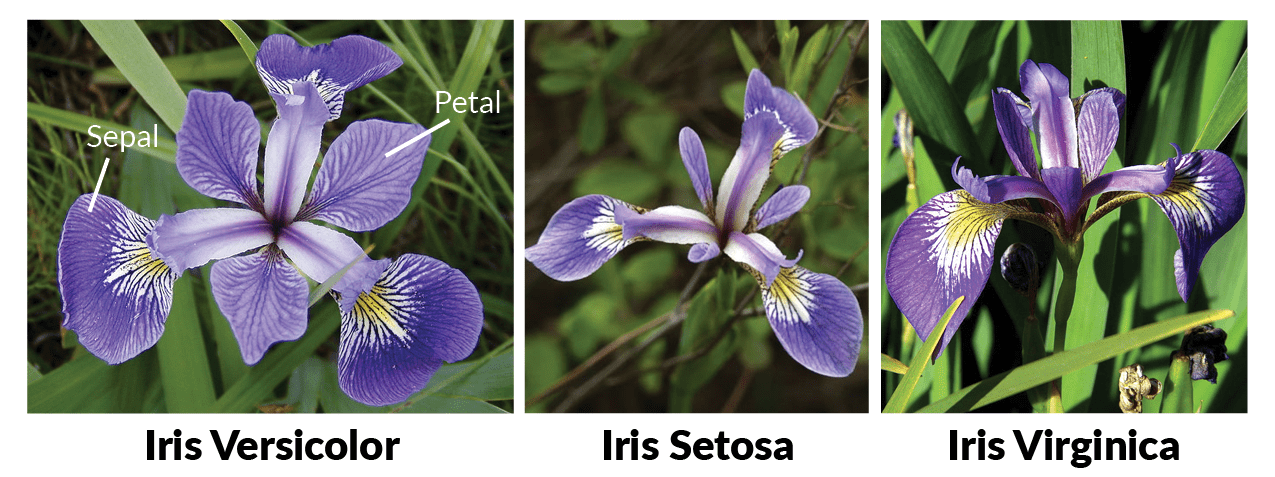





Below, we will read the data from an NPZ file. The file contains four arrays, namely 
- **trnX:** A $90 \times 4$ matrix storing training observations (each row is one training sample)
- **trn_labels:** An array of size 90 storing the associated labels for each row of **trnX**
- **tstX:** A $60 \times 4$ matrix storing test samples (each row is one sample)
- **tst_labels:** An array of size 60 storing the associated labels for each row of **tstX** 

   

In [1]:
import numpy as np
import random

In [2]:
npzfile = np.load('multilayer_perceptron.npz')
trnX = npzfile['trnX']
tstX = npzfile['tstX']
trn_labels = npzfile['trn_labels']
tst_labels = npzfile['tst_labels']

For a softmax classifier, we need to convert our labels to one-hot coded vectors. The code below does this for us. 

In [3]:
def create_one_hot(labels):
    """Convert class labels from scalars to one-hot vectors."""
    num_samples = labels.size
    num_classes = np.unique(labels).size
    labels_one_hot = np.zeros((num_samples, num_classes))
    labels_one_hot[np.arange(num_samples),labels-labels.min()] = 1
    return labels_one_hot

num_samples, num_features = trnX.shape
num_classes = np.unique(trn_labels).size
"""Convert class labels from scalars to one-hot vectors."""
trnY = create_one_hot(trn_labels)
tstY = create_one_hot(tst_labels)

Recall that the softmax classifier has the form
\begin{align} 
p = \mathrm{softmax}\big({z}\big) &= 
\mathrm{softmax}\big({W}^\top {x} \big)\\
\mathrm{softmax}\big({z_1,z_2,\cdots,z_K}\big) &= \frac{1}{\sum_i \exp(z_i)} 
\big(\exp(z_1),\exp(z_2),\cdots,\exp(z_K)\big)^\top
\end{align}

The code below realizes the softmax classifier.

In [4]:
def softmax(x):
    z1 = np.exp(x)
    z = z1.T/np.sum(z1,axis=1)
    return(z.T)

The CE loss (NLL of softmax output) is:

\begin{align}
    \mathcal{L}_{\mathrm{NLL}}\big({W}\big) \triangleq -
    \sum_{i=1}^m {y}_i^\top \log\big(\hat{y}_i\big)\;.   
\end{align}
with $\hat{y}_i = \mathrm{softmax}\big({W}^\top {x}_i \big)$.
The function below implements the NLL loss. Note that we do not scale the loss by a factor of $1/m$ in this example. 

In [5]:
def nll_loss(y,y_hat):
    
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-15

    # Ensure y_hat is not exactly 0 or 1 to prevent log(0) or log(1) issues
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon) # Clip the values in an array

    # Calculate the CE loss
    ce_loss = -np.sum(y * np.log(y_hat))
    return ce_loss

Let us evaluate our softmax classifier first.

In [6]:
# Softmax
W = np.random.randn(num_features,num_classes)

lr = 0.001
max_iter = 500
loss_softmax = []

for iter in range(max_iter):
    h = np.matmul(trnX,W)
    y_hat = softmax(h)
    tmp_loss = nll_loss(trnY,y_hat)
    loss_softmax.append(tmp_loss)
    grad = np.matmul(trnX.T,(y_hat-trnY))
    W -= lr * grad
    
    # computing accuracy
    if np.mod(iter, 10) == 1:
        h = np.matmul(tstX,W)
        y_hat = softmax(h) 
        pred_label = np.argmax(y_hat, axis=1)
        acc_iter = np.mean(pred_label==tst_labels)
        print(f'Softmax - iter:{iter:3} :  loss={tmp_loss:.3f}, test accuracy= {100*acc_iter:.2f}')

Softmax - iter:  1 :  loss=111.027, test accuracy= 33.33
Softmax - iter: 11 :  loss=104.827, test accuracy= 35.00
Softmax - iter: 21 :  loss=99.951, test accuracy= 43.33
Softmax - iter: 31 :  loss=96.153, test accuracy= 63.33
Softmax - iter: 41 :  loss=93.220, test accuracy= 65.00
Softmax - iter: 51 :  loss=90.964, test accuracy= 65.00
Softmax - iter: 61 :  loss=89.225, test accuracy= 65.00
Softmax - iter: 71 :  loss=87.874, test accuracy= 66.67
Softmax - iter: 81 :  loss=86.804, test accuracy= 66.67
Softmax - iter: 91 :  loss=85.939, test accuracy= 80.00
Softmax - iter:101 :  loss=85.218, test accuracy= 91.67
Softmax - iter:111 :  loss=84.601, test accuracy= 93.33
Softmax - iter:121 :  loss=84.057, test accuracy= 78.33
Softmax - iter:131 :  loss=83.565, test accuracy= 68.33
Softmax - iter:141 :  loss=83.110, test accuracy= 66.67
Softmax - iter:151 :  loss=82.682, test accuracy= 66.67
Softmax - iter:161 :  loss=82.275, test accuracy= 66.67
Softmax - iter:171 :  loss=81.882, test accura

## Multilayer Perceptron

Seems we have learned something useful. Now try to perform the following

* Can you add a bias to the model?

* The learning rate is an important parameter of the model. increase it and study the behavior of the algorithm

* The direct implementation of the softmax function is prone to neumerical instabilities. Implement a robust softmax function using the invariance property of the softmax.

* Related to the above, implement a robust loss using the log-sum trick

As for the activation function, we will use a ReLU function defined as

$\mathrm{ReLU}(x) = \max(x,0)$ (see below)
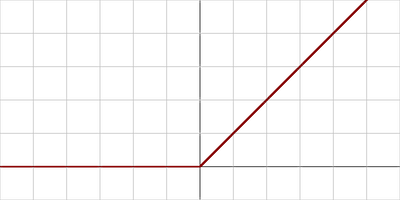

The code below implements the ReLU function.


In [7]:
def relu(x):
    return(np.maximum(x, 0))

Our MLP model has the following structure



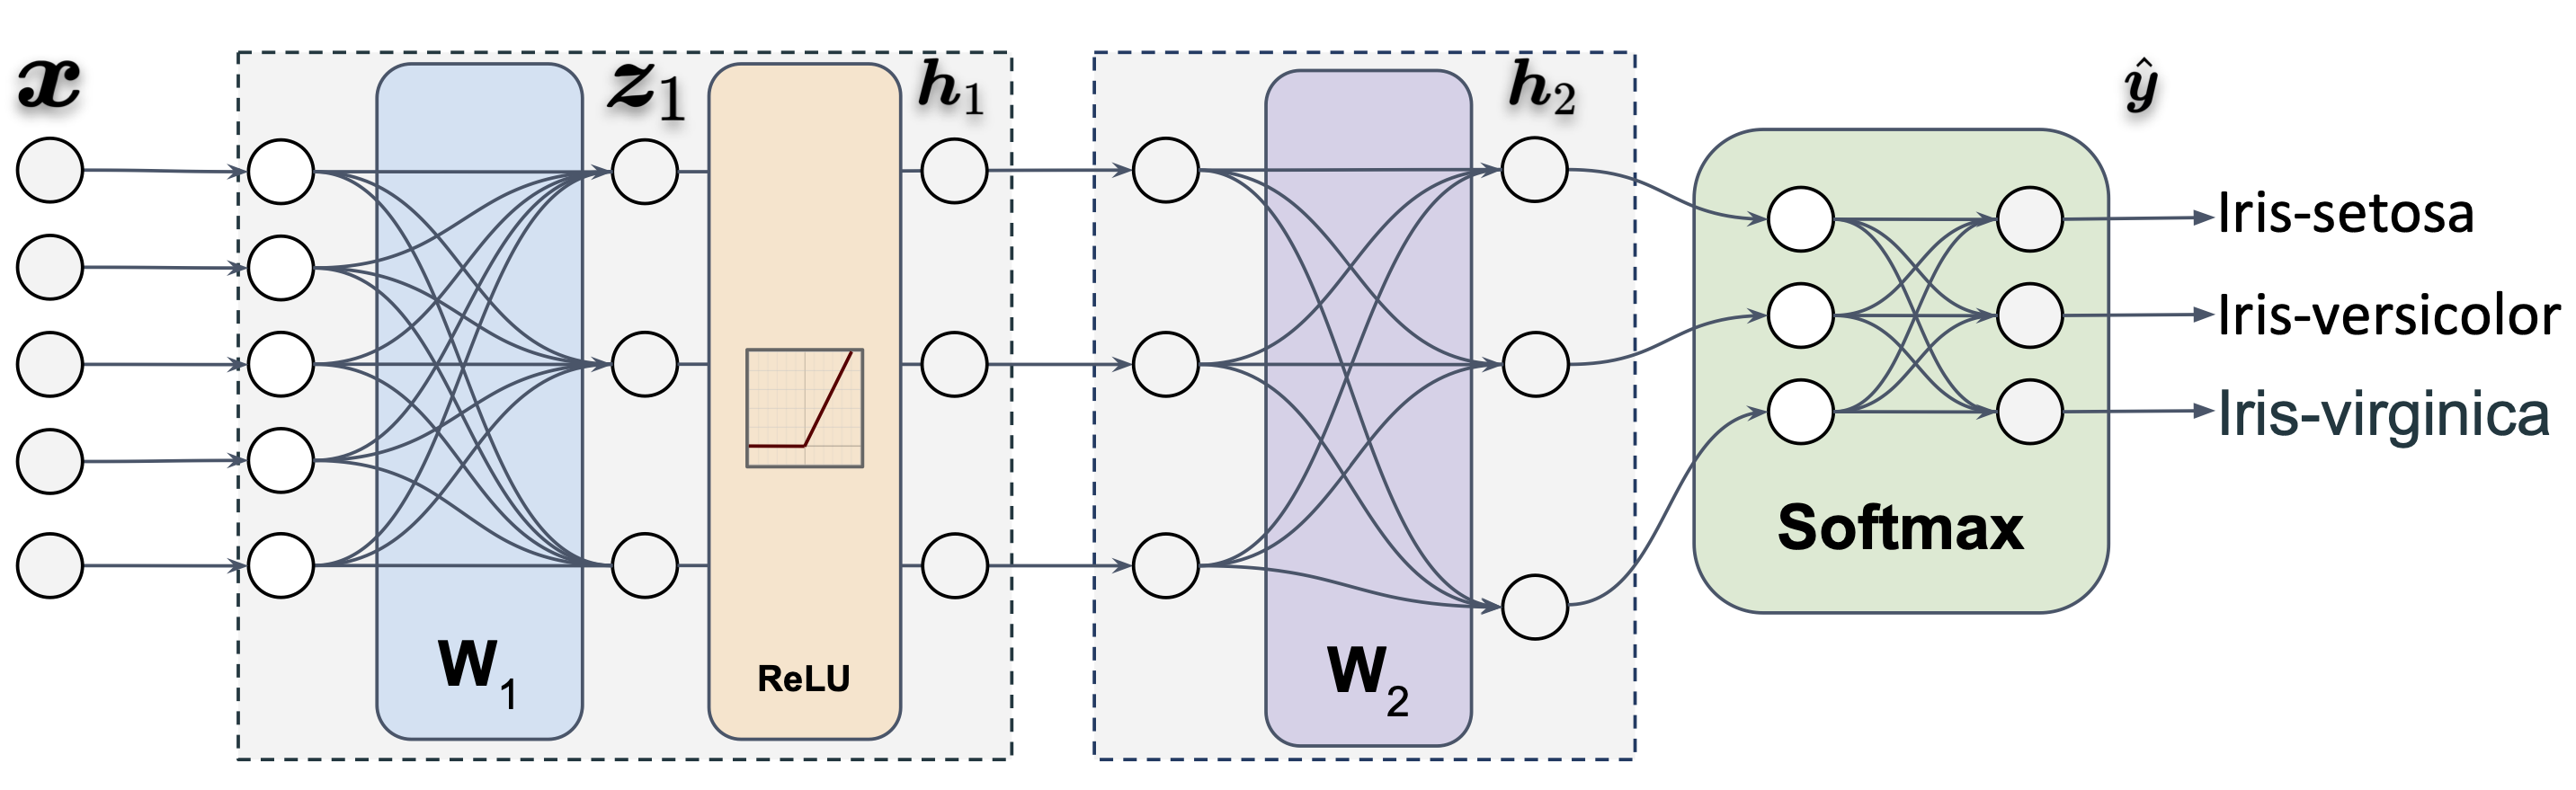


The following equations provide us with the gradient information to perform GD

\begin{align}
\nabla_{W_2}\mathcal{L} &= h_1\Big(\nabla_{h_2}\mathcal{L}\Big)^\top\\
\nabla_{W_1}\mathcal{L} &= x\Big(\nabla_{z_1}\mathcal{L}\Big)^\top\\
\end{align}
with
\begin{align}
\nabla_{h_2}\mathcal{L} &= \hat{y} - y\\
\nabla_{h_1}\mathcal{L} &= W_2\nabla_{h_2}\mathcal{L}\\
\nabla_{z_1}\mathcal{L} &= \nabla_{h_1}\mathcal{L}\odot\mathrm{sign}(h_1)\\
\end{align}

In [8]:
# MLP
n0 = num_features #number of input features
n1 = 100 #size of the hidden layer
n2 = num_classes #number of classes
W1 = np.random.rand(n0,n1)
W2 = np.random.rand(n1,n2)

lr = 0.001
max_iter = 500
loss_mlp = []
for iter in range(max_iter):
    #forward pass
    z1 = np.matmul(trnX,W1)
    h1 = relu(z1)
    h2 = np.matmul(h1,W2)
    y_hat = softmax(h2)  
    
    tmp_loss = nll_loss(trnY,y_hat)
    loss_mlp.append(tmp_loss)
    
    #backward pass
    dldh2 = (y_hat - trnY) 
    dldW2 = np.matmul(h1.T,dldh2)
    
    
    dldh1 = np.matmul(dldh2,W2.T)
    dldz1 = dldh1*np.sign(z1)
    dldW1 = np.matmul(trnX.T,dldz1)
    
    # GD
    W2 -= lr*dldW2
    W1 -= lr*dldW1
    
    if np.mod(iter, 10) == 1:
        h1 = np.matmul(tstX,W1)
        h2 = relu(h1)
        h3 = np.matmul(h2,W2)
        y_hat = softmax(h3) 
        pred_label = np.argmax(y_hat, axis=1)
        acc_iter = np.mean(pred_label==tst_labels)
        print(f'MLP - iter:{iter:3}  loss={tmp_loss:.3f}, test accuracy={100*acc_iter:.2f}')

MLP - iter:  1  loss=120.574, test accuracy=33.33
MLP - iter: 11  loss=90.388, test accuracy=33.33
MLP - iter: 21  loss=84.497, test accuracy=66.67
MLP - iter: 31  loss=79.674, test accuracy=66.67
MLP - iter: 41  loss=75.590, test accuracy=66.67
MLP - iter: 51  loss=72.082, test accuracy=66.67
MLP - iter: 61  loss=69.039, test accuracy=66.67
MLP - iter: 71  loss=66.372, test accuracy=66.67
MLP - iter: 81  loss=64.012, test accuracy=66.67
MLP - iter: 91  loss=61.902, test accuracy=66.67
MLP - iter:101  loss=59.999, test accuracy=66.67
MLP - iter:111  loss=58.265, test accuracy=66.67
MLP - iter:121  loss=56.673, test accuracy=66.67
MLP - iter:131  loss=55.200, test accuracy=66.67
MLP - iter:141  loss=53.825, test accuracy=66.67
MLP - iter:151  loss=52.541, test accuracy=66.67
MLP - iter:161  loss=51.327, test accuracy=66.67
MLP - iter:171  loss=50.173, test accuracy=66.67
MLP - iter:181  loss=49.070, test accuracy=66.67
MLP - iter:191  loss=48.012, test accuracy=66.67
MLP - iter:201  los